In [1]:
cd ~/microbiome_rnn/

/Volumes/export/isn/mwiest/microbiome_rnn


In [2]:
from __future__ import print_function
%matplotlib inline
import os
import torch
import numpy as np
import sys
from otu_handler import OTUHandler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from models.rnn.conv_lstm import *
from models.rnn.lstm import *
from models.enc_dec.encoder_decoder import *
from models.ffn.ffn import *
from models.ffn.conv_ffn import *
from helpers.model_helper import *

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


In [18]:
# Put the model type in here
model_type = 'enc_dec'

model_lookup = {
    'enc_dec': EncoderDecoder,
    'lstm': LSTM,
    'conv_lstm': ConvLSTM,
    'ffn': FFN,
    'conv_ffn': ConvFFN
}

model_outputs = {
    'enc_dec': 'enc_dec_output/',
    'lstm': 'rnn_output/',
    'ffn': 'ffn_output',
    'conv_ffn': 'ffn_output',
    'conv_lstm': 'rnn_output'
}

In [24]:
run_suffix = '_EncDec_h256_sl15_rns25_sif5'
model_name = 'model{}.pt'.format(run_suffix)
log_name = 'log{}.csv'.format(run_suffix)
output_dir = model_outputs[model_type]


# Plot the Training Loss

In [25]:
losses = np.loadtxt(os.path.join(output_dir, log_name), delimiter=',')


Text(0.5,1,'Loss Over Training')

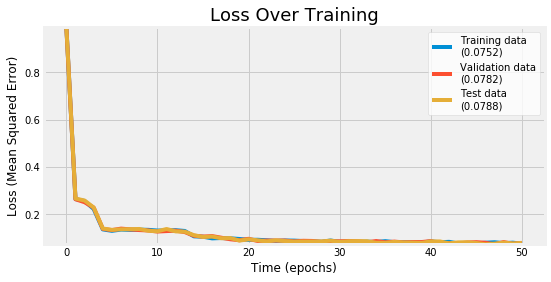

In [26]:
loss_num_digits = 6

plt.figure(figsize=(8, 4))
plt.plot(losses[0, :].T, label='Training data\n({})'.format(str(losses[0, -1])[:loss_num_digits]))
plt.plot(losses[1, :].T, label='Validation data\n({})'.format(str(losses[1, -1])[:loss_num_digits]))
if losses.shape[0] == 3:
    plt.plot(losses[2, :].T, label='Test data\n({})'.format(str(losses[2, -1])[:loss_num_digits]))
legend = plt.legend(frameon = 1, loc='upper right')
frame = legend.get_frame()
frame.set_facecolor('white')
plt.xlabel('Time (epochs)')
plt.ylabel('Loss (Mean Squared Error)')
plt.ylim(losses.min(), losses.max())
plt.title('Loss Over Training', fontsize=18)


# Model "Dreaming" Analysis

In [27]:
# Instantiate an OTU Handler.
input_dir = 'all_studies_reduced_62/'
files = []
for (dirpath, dirnames, filenames) in os.walk(input_dir):
    files.extend(filenames)
    break
files = [os.path.join(input_dir, f) for f in files if not f.endswith('_clr.csv')]
otu_handler = OTUHandler(files)
otu_handler.normalize_data()

In [28]:
# Instantiate the model
hidden_dim = 256
reduced_num_strains = 25
slice_len = 25
use_gpu = torch.cuda.is_available()


# Basically load the correct type of model. 
if model_type == 'enc_dec' or model_type.endswith('lstm'):
    model = model_lookup[model_type](hidden_dim, otu_handler, use_gpu, LSTM_in_size=reduced_num_strains)
else:
    model = model_lookup[model_type](hidden_dim, otu_handler, slice_len, use_gpu)
    
model.load_state_dict(torch.load(os.path.join(output_dir, model_name)))
model = model.cuda()

In [130]:
# Get some primer data
sample_index = 1
sample_start_range = 40
sample_end_range = 55
primer = otu_handler.samples[sample_index].values[:, sample_start_range: sample_end_range]
# Need to make it 3d because the last dimension is how many predictions to do at once. 
primer = np.expand_dims(primer, -1)
print('Sample is of shape: {}'.format(primer.shape))

Sample is of shape: (62, 15, 1)


In [131]:
dream_length = 100
dream = model.daydream(primer, predict_len=dream_length)
print(dream.shape)

# Get the comparison data.
comparison = otu_handler.samples[sample_index].values[:, sample_start_range:dream_length + sample_end_range]

c2 = otu_handler.raw_samples[sample_index].values[:, sample_start_range:dream_length + sample_end_range]
# Unnormalize the output data.
dream_un = otu_handler.un_normalize_data(dream, sample_index, (sample_start_range, sample_end_range))
comparison_un = otu_handler.un_normalize_data(comparison, sample_index, (sample_start_range, sample_end_range))


(62, 115, 1)


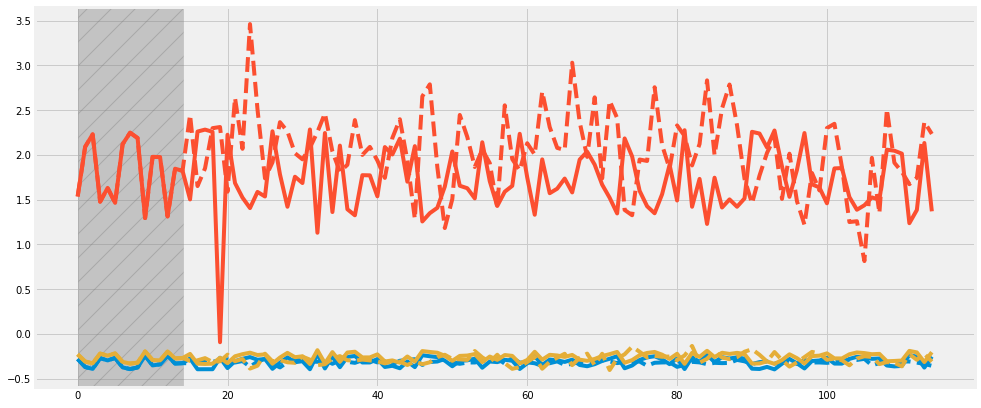

In [132]:
plt.figure(figsize=(15, 7))
r = range(4, 7)

for i, ri in enumerate(r):
    plt.plot(dream[ri, :, 0].T, ls='--', c=colors[i])
    plt.plot(comparison[ri, :].T, c=colors[i])
plt.axvspan(0, (sample_end_range - sample_start_range) - 1, alpha=0.4, color='gray',
            label='Priming Region', hatch='/')

# Analysis of strain compression step.
Certain models have a step where the number of strains is compressed from `N` inputs to `M` outputs where `M < N`. Ideally this serves to give the LSTM an easier time.

In [123]:
# Extract the values from the network
compressor_vals = model.strain_compressor[0].weight.data.cpu().numpy()

Sequential(
  (0): Linear(in_features=62, out_features=256, bias=True)
  (1): Tanh()
  (2): Dropout(p=0.5)
  (3): Linear(in_features=256, out_features=25, bias=True)
  (4): Tanh()
)


In [124]:
# Do PCA on the data
pca = PCA(n_components=2)
pca.fit(compressor_vals.T)
trans = pca.transform(compressor_vals.T)
pca.explained_variance_ratio_

array([0.04702356, 0.03772788], dtype=float32)

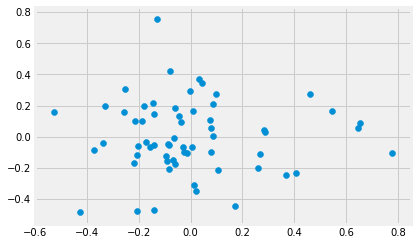

In [104]:
plt.scatter(trans[:, 0], trans[:, 1])